In [98]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tflearn
import collections
import time
#import tensorflow.contrib import rnn
import random
from datetime import timedelta
from zipfile import ZipFile

In [99]:
start_time = time.time()

def elapsed(sec):
    if sec<60:
        return str(sec) + " sec"
    elif sec<(60*60):
        return str(sec/60) + " min"
    else:
        return str(sec/(60*60)) + " hr"

In [100]:
logs_path = '/home/user/Downloads/proj/logs/'
writer = tf.summary.FileWriter(logs_path)

We will run the data through 20 epochs, in batch sizes of 250 .

The maximum length of each text we will consider is 25 words; we will cut longer texts to 25 or zero pad shorter texts.

The RNN will be of size 10 units.

We will only consider words that appear at least 10 times in our vocabulary, and every word will be embedded in a trainable vector of size 50 .

The dropout rate will be a placeholder that we can set at 0.5 during training time or 1.0 during evaluation:

fname is file_name which is in the form of txt

In [101]:
def read_data(fname):
    with open(fname) as f:
        content = f.readlines()
    content = [x.strip() for x in content]
    content = [content[i].split() for i in range(len(content))]
    content = np.array(content)
    content = np.reshape(content,[-1, ])
    return content

Now we get the SMS text data.First, we check if it was already downloaded and, if so,read in the file.

Otherwise, we download the data and save it:

In [102]:
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.isfile(os.path.join(data_dir, data_file)):
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
# Format Data
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    # Save data to text file
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    # Open data from text file
    text_data = []
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
        text_data = text_data[:-1]
text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

In [103]:
text_data_train

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n',
 'Ok lar... Joking wif u oni...\n',
 "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n",
 'U dun say so early hor... U c already then say...\n',
 "Nah I don't think he goes to usf, he lives around here though\n",
 "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, 1.50 to rcv\n",
 'Even my brother is not like to speak with me. They treat me like aids patent.\n',
 "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune\n",
 'WINNER!! As a valued network customer you have been selected to receivea 900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours onl

In [104]:
# To reduce our vocabulary, we will clean the input texts by removing special
# characters, extra white space, and putting everything in lowercase:

def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return(text_string)

# Clean texts
text_data_train = [clean_text(x) for x in text_data_train]

In [105]:
text_data_train

['go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat',
 'ok lar joking wif u oni',
 'free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry questionstd txt ratetcs apply overs',
 'u dun say so early hor u c already then say',
 'nah i dont think he goes to usf he lives around here though',
 'freemsg hey there darling its been weeks now and no word back id like some fun you up for it still tb ok xxx std chgs to send to rcv',
 'even my brother is not like to speak with me they treat me like aids patent',
 'as per your request melle melle oru minnaminunginte nurungu vettam has been set as your callertune for all callers press to copy your friends callertune',
 'winner as a valued network customer you have been selected to receivea prize reward to claim call claim code kl valid hours only',
 'had your mobile months or more u r entitled to update to the latest colour mobiles with camera for free call the mobil

Now we process the texts with a built-in vocabulary processor function from TensorFlow.

This will convert a text to an appropriate list of indices:

In [106]:
# we need to reset the graph inorder to use the same tensorboard for computation
tf.reset_default_graph()

In [107]:
epochs = 30
batch_size = 250
max_sequence_length = 25 # n_input
rnn_size = 10 # no of units in rnn cell
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

In [108]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequence_length,min_frequency=min_word_frequency)
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

In [109]:
# text_data_train

text_processed 

array([[ 44, 455,   0, ...,   0,   0,   0],
       [ 47, 315,   0, ...,   0,   0,   0],
       [ 46, 465,   9, ...,   0, 368,   0],
       ...,
       [  0,  59,   9, ...,   0,   0,   0],
       [  5, 493, 108, ...,   1, 198,  12],
       [  0,  40, 474, ...,   0,   0,   0]])

In [110]:
# Next we shuffle the data to randomize the data:

text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])
print(text_data_target)
shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))
x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

[1 1 0 ... 1 1 1]


For this recipe, we will not be doing any hyperparameter tuning. If the reader
goes in this direction, remember to split up the dataset into train-test-valid
sets before proceeding. 

A good option for this is the Scikit-learn function model_selection.train_test_split().

In [111]:
# We also split the data into an 80-20 train-test dataset:

ix_cutoff = int(len(y_shuffled)*0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]

vocab_size = len(vocab_processor.vocabulary_)

print("Vocabulary Size: {:d}".format(vocab_size))
print("80-20 Train Test split: {:d} -- {:d}".format(len(y_train),len(y_test)))

Vocabulary Size: 933
80-20 Train Test split: 4459 -- 1115


Next we declare the graph placeholders.The x-input will be a placeholder of size [None, max_sequence_length] , which will be the batch size by the maximum
allowed word length of the text messages.

The y-output placeholder is just an integer, 0 or 1, or ham or spam:

In [112]:
x_data = tf.placeholder(tf.int32, [None, max_sequence_length]) # x= tf.placeholder(tf.float32, [None, n_input, 1])
y_output = tf.placeholder(tf.int32, [None]) # y = tf.placeholder(tf.float32, [None,vocab_size])

In [113]:
#RNN output node weights and bias,
#if in case you're not using any pretrained model for weights

# weights ={
#     'out' : tf.Variable(tf.random_normal([n_hidden,vocab_size]))
# }
# biases = {
#     'out' : tf.Variable(tf.random_normal([vocab_size]))
# }

In [114]:
#We now create our embedding matrix and embedding lookup operation for the x-input data:

embedding_mat = tf.Variable(tf.random_uniform([vocab_size,embedding_size], -1.0, 1.0))
embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

In [115]:
# def RNN(x,weights,biases):
    
#     # reshape to [1,n_input]
#     x = tf.reshape(x, [-1, n_input])
    
#     #Generate a n_input-element sequence of integers
#     # eg. [had] [a] [general] --> [20] [6] [33]
#     x = tf.split(x,n_input,1)
    
#     #2-layer LSTM, each layer has n_hidden units.
#     #Average acc = 95%
#     rnn_cell = rnn.MultiRNNCell([rnn.BasicLSTMCell(n_hidden),rnn.BasicLSTMCell(n_hidden)])
    
#     # 1-layer LSTM with n_hidden units but with lower accuracy
#     #Uncomment below line to test but comment 2 lstm
#     # rnn_cell = rnn.BasicLSTMCell(n_hidden)
    
#     # generate predictions
#     outputs, state = rnn.static_rnn(rnn_cell, x , dtype = tf.float32)
    
#     #THERE Are n_input outputs but
#     # we want only last output
#     return tf.matmul(outputs[-1] , weights['out']) + biases['out']
#pred = RNN(x,weights, biases)

In [116]:
#We declare our model as follows.
#First we initialize a type of RNN cell to use (RNN of size 10).
#Then we create the RNN sequence by making it a dynamic RNN.We then add dropout to the RNN:


#cell = tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size) # num_units = num_hidden_units in RNN/LSTM
#if we use multiple RNN CELLS THEN WE SHOULD WRITE MULTIPLE CELLS

cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size),tf.nn.rnn_cell.BasicRNNCell(num_units = rnn_size)])
output, state = tf.nn.dynamic_rnn(cell, embedding_output,dtype=tf.float32)
output = tf.nn.dropout(output, dropout_keep_prob)

In [117]:
# Now to get our predictions, we have to rearrange the RNN and slice off the last output:

# EVEN THOUGH WE HAVE n_input outputs, we want only the last output. so we slice off the last output

output = tf.transpose(output, [1, 0, 2])
last = tf.gather(output, int(output.get_shape()[0]) - 1)

In [118]:
# To finish the RNN prediction, we convert from the rnn_size output to the
# two-category output via a fully connected network layer:

weight = tf.Variable(tf.truncated_normal([rnn_size, 2],stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

#predictions = logits_out

In [119]:
#We declare our loss function next.Remember that with using the sparse_softmax
#function from TensorFlow, the targets have to be integer indices (of type int ), and
# the logits have to be floats:

losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits_out, labels = y_output)
loss = tf.reduce_mean(losses)

In [120]:
#We also need an accuracy function so that we can compare the algorithm on the test and train set:

# correct_pred = tf.equal(tf.argmax(logits_out,1),tf.argmax(y_output,1))
# accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out,1), tf.cast(y_output, tf.int64)), tf.float32))

In [121]:
# Next we create the optimization function and initialize the model variables:

optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

/home/user/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Now we can start looping through our data and training the model.When looping
through the data multiple times, it is good practice to shuffle the data every epoch to
prevent over-training:

In [122]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
writer = 
with tf.Session() as sess:
    sess.run(init)
    # Start training
    for epoch in range(epochs):
        # Shuffle training data(very important)
        shuffled_ix = np.random.permutation(np.arange(len(x_train)))
        x_train = x_train[shuffled_ix]
        y_train = y_train[shuffled_ix]
        num_batches = int(len(x_train)/batch_size) + 1
        for i in range(num_batches):
            # Select train data
            min_ix = i * batch_size
            max_ix = np.min([len(x_train), ((i+1) * batch_size)])
            x_train_batch = x_train[min_ix:max_ix]
            y_train_batch = y_train[min_ix:max_ix]
            #Run train step
            train_dict = {x_data: x_train_batch, y_output: y_train_batch, dropout_keep_prob:0.5}
            sess.run(train_step, feed_dict=train_dict)
            # Run loss and accuracy for training
            temp_train_loss, temp_train_acc = sess.run([loss, accuracy],feed_dict=train_dict)
        train_loss.append(temp_train_loss)
        train_accuracy.append(temp_train_acc)
        # Run Eval Step
        test_dict = {x_data: x_test, y_output: y_test, dropout_keep_prob:1.0}
        temp_test_loss, temp_test_acc = sess.run([loss, accuracy],feed_dict=test_dict)
        test_loss.append(temp_test_loss)
        test_accuracy.append(temp_test_acc)
        print('Epoch: {}, val Loss: {:.2}, val Acc: {:.2}'.format(epoch+1, temp_test_loss, temp_test_acc))
#     end_time = time.time()
#     time_delta = end_time - start_time
    print("elapsed_time : " , elapsed(time.time() - start_time) )
    while True:
        prompt = "%s words: " % n_input
        sentence = input(prompt)
        sentence = sentence.strip()
        words = sentence.split('')
        if len(words) ! = n_input:
            continue
        try:
            symbols_in_keys = [dictionary[str(words[i])] for i in range(len(words))]
            for i in range(32):
                keys = np.reshape(np.array(symbols_in_keys), [-1,n_input,1] )
                onehot_pred = session.run(pred, feed_dict = {x:keys})
                onehot_pred_index = int(tf.argmax(onehot_pred,1).eval())
                sentence = "%s %s" % (senetence , reverse_dictionary[one_hot_pred_index])
                symbols_in_keys = symbols_in_keys[1:]
                symbols_in_keys.append(onehot_pred_index)
            print(sentence)
        except:
            print("Word not in deictionary")
                

Epoch: 1, val Loss: 0.74, val Acc: 0.17
Epoch: 2, val Loss: 0.72, val Acc: 0.17
Epoch: 3, val Loss: 0.69, val Acc: 0.82
Epoch: 4, val Loss: 0.65, val Acc: 0.84
Epoch: 5, val Loss: 0.62, val Acc: 0.85
Epoch: 6, val Loss: 0.58, val Acc: 0.86
Epoch: 7, val Loss: 0.56, val Acc: 0.86
Epoch: 8, val Loss: 0.54, val Acc: 0.86
Epoch: 9, val Loss: 0.52, val Acc: 0.86
Epoch: 10, val Loss: 0.5, val Acc: 0.87
Epoch: 11, val Loss: 0.49, val Acc: 0.87
Epoch: 12, val Loss: 0.48, val Acc: 0.87
Epoch: 13, val Loss: 0.47, val Acc: 0.87
Epoch: 14, val Loss: 0.47, val Acc: 0.87
Epoch: 15, val Loss: 0.46, val Acc: 0.87
Epoch: 16, val Loss: 0.46, val Acc: 0.87
Epoch: 17, val Loss: 0.46, val Acc: 0.87
Epoch: 18, val Loss: 0.45, val Acc: 0.87
Epoch: 19, val Loss: 0.45, val Acc: 0.87
Epoch: 20, val Loss: 0.45, val Acc: 0.87
Epoch: 21, val Loss: 0.45, val Acc: 0.87
Epoch: 22, val Loss: 0.45, val Acc: 0.87
Epoch: 23, val Loss: 0.44, val Acc: 0.87
Epoch: 24, val Loss: 0.41, val Acc: 0.89
Epoch: 25, val Loss: 0.4, 

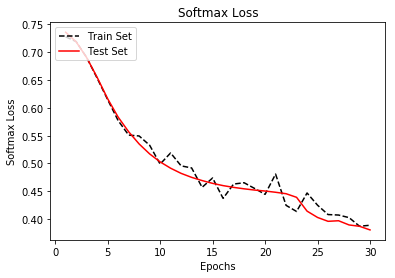

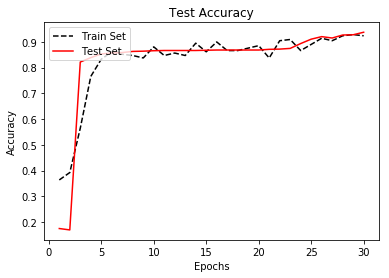

In [123]:
# Here is the code to plot the train / test loss and accuracy:
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label='Train Set')
plt.plot(epoch_seq, test_loss, 'r-', label='Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.ylabel('Softmax Loss')
plt.legend(loc='upper left')
plt.show()

# Plot accuracy over time
plt.plot(epoch_seq, train_accuracy, 'k--', label='Train Set')
plt.plot(epoch_seq, test_accuracy, 'r-', label='Test Set')
plt.title('Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()